# Logistic Regression and its application

This notebook is about the implementation of logistic regression. I will implement it step by step and at the last part of the notebook, I will use my function to train a dataset

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 


%matplotlib notebook

## 1. Logistic regression step by step

I will use some help functions for the logistic regression algorithms

In [53]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s=1/(1+np.exp(-z))  
    return s

In [3]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w=np.zeros((dim,1))
    b=0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w,b

In [4]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (number of features, 1)
    b -- bias, a scalar
    X -- data of size (number of features, number of examples)
    Y -- true "label" vector (containing 0 if is true, 1 if false) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    num_of_example=X.shape[1] ## number of examples
    A=sigmoid(np.dot(w.T,X)+b)  ## vectorization version of sigmoid function for each example shape is (1, number of examplex)
    cost= (-1.0/num_of_example)*(Y*np.log(A)+(1-Y)*np.log(1-A)).sum() ## log-likelihood cost for logistic regression
    
    dw=(1.0/num_of_example)*np.dot(X,(A-Y).T) ## this is the derivative wrt w_i shape=(number of features,1)
    db=(1.0/num_of_example)*(A-Y).sum()  ## this is the derivative wrt b_i shape= a number
    
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grade={"dw":dw,"db":db}
    return grade,cost

In [5]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (number_of_features, 1)
    b -- bias, a scalar
    X -- data of shape (number_of_features, number of examples)
    Y -- true "label" vector (containing 0 if true, 1 if false), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    num_of_iter=0
    
    costs=[]
    
    while (num_of_iter<num_iterations):
        
        ## this is the forward propagation
        grade,cost=propagate(w,b,X,Y)
        
        ## here is the update step, which we update the coefficient w, b for the next iteration
        w=w-learning_rate*grade['dw']
        b=b-learning_rate*grade['db']
        
        if (num_of_iter%100==0):
            costs.append(cost)
        
        if (print_cost==True and num_of_iter%100==0):
            print (cost)
            
        num_of_iter=num_of_iter+1
        
    params={"w":w,
           "b":b}
    
    grads={"dw":grade['dw'],
          "db":grade['db']}
    
    return params,grads,costs
    

In [6]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (number_of_features, 1)
    b -- bias, a scalar
    X -- data of size (number_of_features, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    ## get the number of examples
    m=X.shape[1]
    ## make predictions array for return
    Y_prediction=np.zeros((1,m),dtype=int)
    
    
    ## sigmoid function array
    A=sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        if (A[0,i]>=0.5):
            Y_prediction[0,i]=1
        else:
            Y_prediction[0,i]=0
            
    return Y_prediction

In [7]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (number of features, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (number of features, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    num_feature=X_train.shape[0]
    
    ## initialize w and b
    w_0,b_0=initialize_with_zeros(num_feature)
    
    ## find the final parameters for further calculation
    parameters, grads, costs=optimize(w_0, b_0, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples 
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
    

## 2. Use data set to test our algorithm

This dataset is from Springboard male and femal dataset, which is a very very simple dataset to see the binary claasification problme

In [8]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [10]:
dflog['gender']=dflog['Gender'].apply(lambda x:1 if x=='Male' else 0)

In [11]:
dflog.head()

,Gender,Height,Weight,gender
0,Male,73.847017,241.893563,1
1,Male,68.781904,162.310473,1
2,Male,74.110105,212.740856,1
3,Male,71.730978,220.042470,1
4,Male,69.881796,206.349801,1


<IPython.core.display.Javascript object>


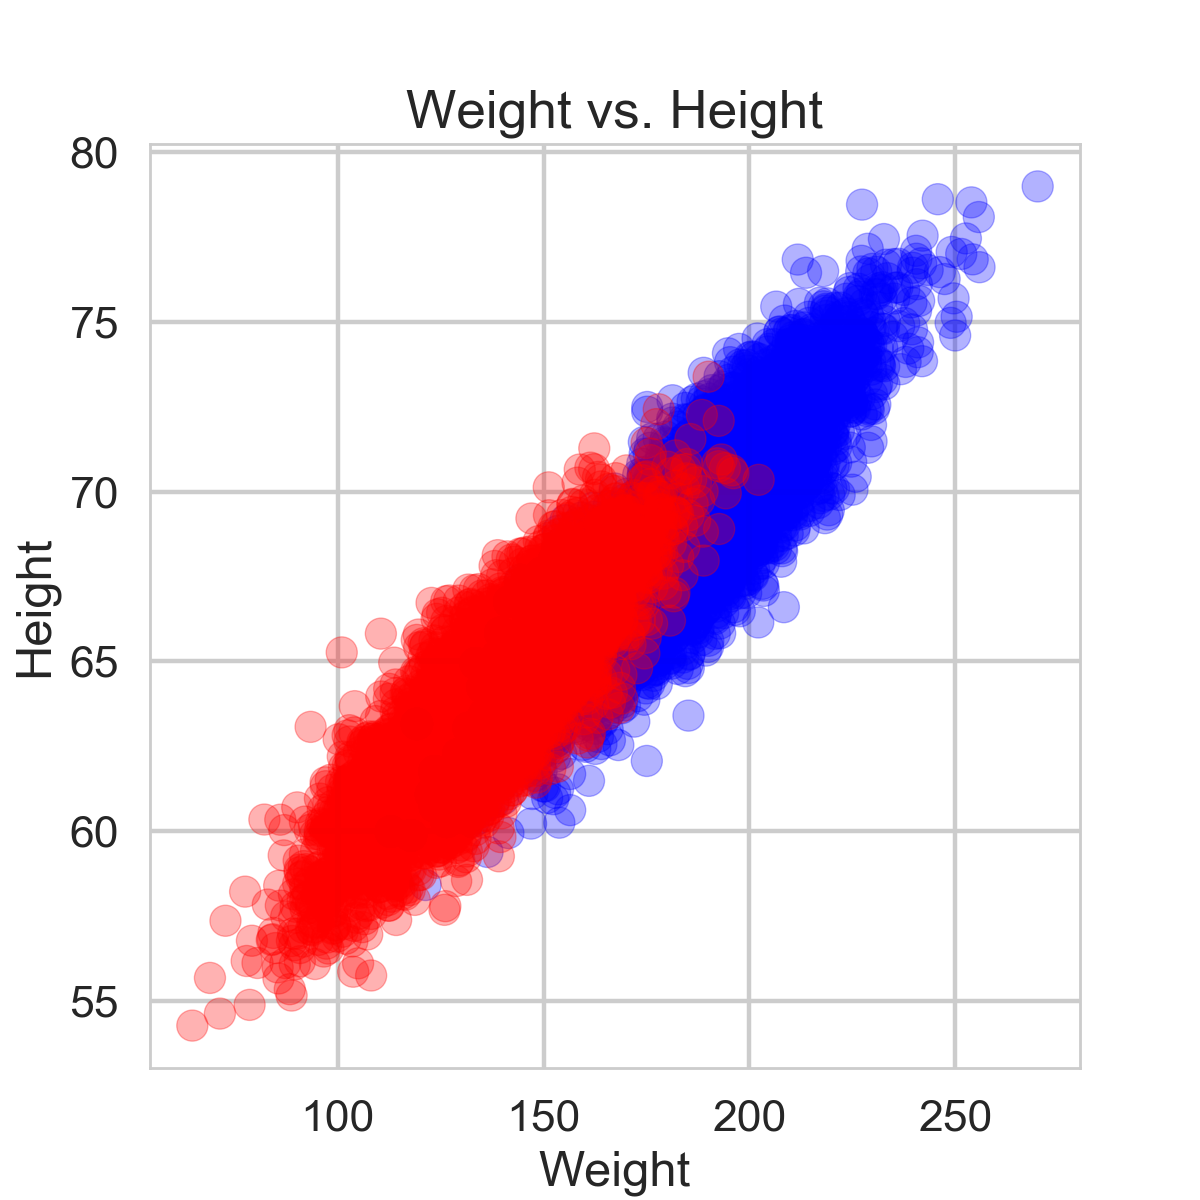

In [80]:
figure=plt.figure(figsize=(6,6))
plt.scatter(dflog['Weight'], dflog['Height'],c=dflog['gender'], cmap=cm_bright,alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Weight vs. Height")

**Some comments**

This dataset, from the picture shows, is balanced. So that our logistic regression could be used directly without worring about the resampling process. The accuracy of the model could be measured by the accuracy rate. There is no need to use recall and precision and ROC curve

In [141]:
## train test splitting

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(dflog[['Height','Weight']].values,dflog['gender'].values,random_state=5)

In [142]:
## reshape the dataset inorder to use my own algorithm

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(7500, 2)
(2500, 2)
(7500,)
(2500,)


In [143]:
X_train=X_train.T
X_test=X_test.T
y_train.reshape((1,y_train.shape[0]))
y_test.reshape((1,y_test.shape[0]))


array([[0, 1, 1, ..., 0, 0, 1]], dtype=int64)

In [144]:

## This is the standarization of the dataset, because the exponential function will be
## overflow we the argument x tends to negative infinite.



X_train=(X_train-X_train.mean(axis=1).reshape((2,1)))/X_train.std(axis=1).reshape((2,1))
X_test=(X_test-X_test.mean(axis=1).reshape((2,1)))/X_test.std(axis=1).reshape((2,1))

In [145]:
## train the model and test it!!


result=model(X_train, y_train, X_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False)

train accuracy: 91.68 %
test accuracy: 92.6 %


In [146]:
result.keys()

dict_keys(['costs', 'Y_prediction_test', 'Y_prediction_train', 'w', 'b', 'learning_rate', 'num_iterations'])

In [149]:
w=result['w']
b=result['b']

x_range=np.dot(w.T,X_test)+b

args=np.argsort(x_range) ## argument of x_range
xx=np.array(x_range[0])[args]
farray=np.array(result['Y_prediction_test'][0])[args] ## argument sort the prediction value on test

<IPython.core.display.Javascript object>


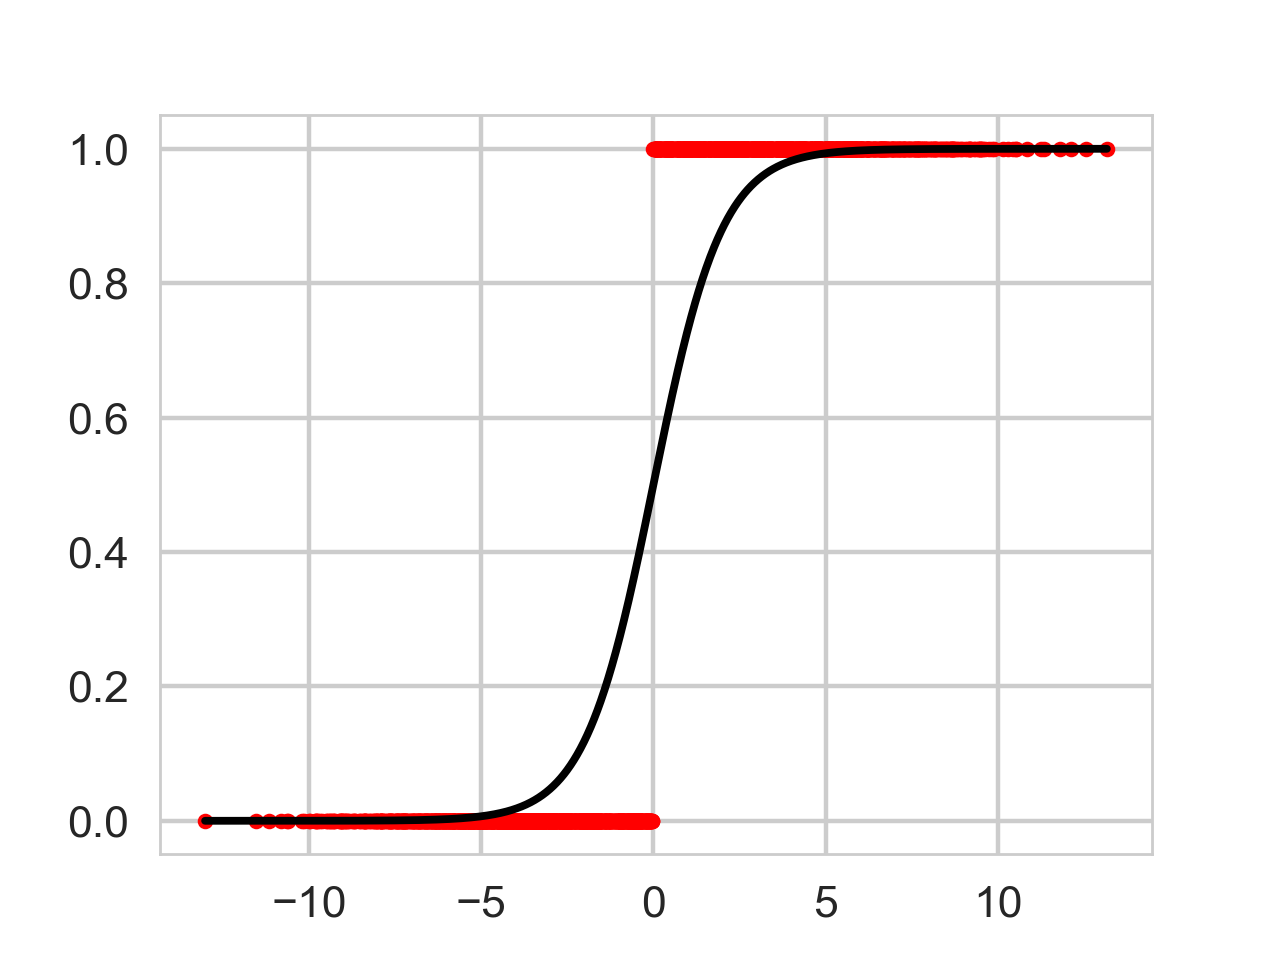

In [150]:
plt.plot(xx[0],farray[0],'r.')
plt.plot(xx[0],sigmoid(xx[0]),'k-')
plt.show()